# Scaling clustering

This notebook explores methods beyond spectral clustering to perform clustering of samples. We'll use 
random projections to reduce the dimensionality of the gradients.

In [2]:
from collections import defaultdict
import pathlib
import os
import sys
import argparse

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import sklearn.cluster

import datasets
from transformers import AutoTokenizer, GPTNeoXForCausalLM

from fast_pytorch_kmeans import KMeans

In [3]:
class SparseProjectionOperator:
    """
    Note: I think the sparsity is off by a factor of two here.
    """
    def __init__(self, original_dim, projection_dim, sparsity, seed=0, device='cpu'):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed) if 'cuda' in str(device) else None
        self.device = torch.device(device)
        self.original_dim = original_dim
        self.lambda_ = original_dim * (1 - sparsity)
        num_entries = torch.poisson(self.lambda_ * torch.ones(projection_dim, device=device)).int()
        max_entries = num_entries.max()
        self.positives = torch.randint(0, original_dim, (projection_dim, max_entries), device=device)
        self.negatives = torch.randint(0, original_dim, (projection_dim, max_entries), device=device)
        masks = torch.arange(max_entries, device=device).expand(projection_dim, max_entries) < num_entries.unsqueeze(-1)
        self.positives = self.positives * masks
        self.negatives = self.negatives * masks
    
    def __call__(self, x):
        assert x.device == self.device, "device mismatch between projection and input"
        assert x.shape[-1] == self.original_dim, "input dimension mismatch"
        y = x[self.positives].sum(-1) - x[self.negatives].sum(-1)
        return y

In [4]:
model_name = "pythia-70m-v0"
step = 143000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cache_dir = "/om/user/ericjm/quanta-discovery/cache/"
pile_canonical = "/om/user/ericjm/the_pile/the_pile_test_canonical_200k"
loss_threshold = 0.5 # 0.5-bit threshold
skip = 10
num_tokens = 100000
proj_dim = 5000
sparsity = 0.999
filter = "/om/user/ericjm/quanta-discovery/cache/pythia-70m-v0/step143000/20000_docs_10658635_tokens_present_trigram_filter.pt"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir=os.path.join(cache_dir, model_name, f"step{step}"),
)

# ----- load the_pile test set -----
dataset = datasets.load_from_disk(pile_canonical)

def tokenize_sample(sample):
    tokens = tokenizer(sample["text"], return_tensors='pt', 
                        max_length=1024, truncation=True)["input_ids"]
    return {"input_ids": tokens}

starting_indexes = np.array([0] + list(np.cumsum(dataset["preds_len"])))

def loss_idx_to_dataset_idx(idx):
    """given an idx in range(0, 10658635), return
    a sample index in range(0, 20000) and pred-in-sample
    index in range(0, 1023). Note token-in-sample idx is
    exactly pred-in-sample + 1"""
    sample_index = np.searchsorted(starting_indexes, idx, side="right") - 1
    pred_in_sample_index = idx - starting_indexes[sample_index]
    return int(sample_index), int(pred_in_sample_index)

def get_context(idx):
    """given idx in range(0, 10658635), return dataset sample
    and predicted token index within sample, in range(1, 1024)."""
    sample_index, pred_index = loss_idx_to_dataset_idx(idx)
    return dataset[sample_index], pred_index+1

def print_context(idx):
    """
    given idx in range(0, 10658635), print prompt preceding the corresponding
    prediction, and highlight the predicted token.
    """
    sample, token_idx = get_context(idx)
    prompt = sample["split_by_token"][:token_idx]
    prompt = "".join(prompt)
    token = sample["split_by_token"][token_idx]
    print(prompt + "\033[41m" + token + "\033[0m")

/om2/user/ericjm/miniconda3/envs/phase-changes/lib/python3.8/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [6]:
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir=os.path.join(cache_dir, model_name, f"step{step}"),
).to(device)

In [7]:
particular_model_cache_dir = os.path.join(cache_dir, model_name, f"step{step}")
losses_cached = [f for f in os.listdir(particular_model_cache_dir) if f.endswith("losses.pt")]
max_i = max(list(range(len(losses_cached))), key=lambda i: int(losses_cached[i].split("_")[0]))
docs, tokens = int(losses_cached[max_i].split("_")[0]), int(losses_cached[max_i].split("_")[2])
losses = torch.load(os.path.join(particular_model_cache_dir, f"{docs}_docs_{tokens}_tokens_losses.pt"))
c = 1 / np.log(2) # for nats to bits conversion

if filter:
    criterias = torch.load(filter)
    token_idxs = ((losses < (loss_threshold / c)) & (~criterias)).nonzero().flatten()
else:
    token_idxs = (losses < (loss_threshold / c)).nonzero().flatten()
token_idxs = token_idxs[::skip]
token_idxs = token_idxs[:num_tokens].tolist()
assert len(token_idxs) == num_tokens, "not enough tokens meeting loss threshold (and filter) to sample from"

In [8]:
# ----- make the magic happen -----
def get_flattened_gradient(model, param_subset):
    grads = []
    for name, p in model.named_parameters():
        if name in param_subset:
            grads.append(p.grad)
    return torch.cat([g.flatten() for g in grads])
param_names = [n for n, _ in model.named_parameters()]

highsignal_names = [name for name in param_names if 
                        ('layernorm' not in name) and 
                        ('embed' not in name)]

len_g = sum(model.state_dict()[name].numel() for name in highsignal_names)
S = len(token_idxs)
R = SparseProjectionOperator(len_g, proj_dim, sparsity, seed=0, device=device)
Gs = torch.zeros((S, proj_dim), device=device)

In [9]:
# for i, idx in tqdm(list(enumerate(token_idxs))):
#     model.zero_grad()
#     document, l = get_context(idx)
#     prompt = document['text']
#     tokens = tokenizer(prompt, return_tensors='pt', max_length=1024, truncation=True).to(device)
#     logits = model(**tokens).logits
#     targets = tokens.input_ids
#     ls = torch.nn.functional.cross_entropy(logits[0, :-1, :], targets[0, 1:], reduction='none')
#     ls_l = ls[l-1]
#     ls_l.backward()
#     g = get_flattened_gradient(model, highsignal_names)
#     with torch.no_grad():
#         Gs[i] = R(g)

In [10]:
# Gs_cpu = Gs.to('cpu')
# torch.save(Gs_cpu, 'Gs.pt')

In [11]:
Gs = torch.load("../scripts/tmp/Gs.pt")

In [15]:
Gs = Gs.to(device)

In [16]:
Gs.device

device(type='cuda', index=0)

In [18]:
kmeans = KMeans(n_clusters=10000, 
                max_iter=100,
                mode='cosine', 
                verbose=1)

In [21]:
labels = kmeans.fit_predict(Gs)

used 29 iterations (82.4509s) to cluster 100000 items into 10000 clusters


In [28]:
labels = [l.item() for l in labels]

In [31]:
label_counts = defaultdict(int)
for label in labels:
    label_counts[label] += 1

labels_sorted_by_cluster_size = sorted(label_counts.keys(), key=lambda l: label_counts[l], reverse=True)
sizes_sorted_by_cluster_sizes = [label_counts[l] for l in labels_sorted_by_cluster_size]

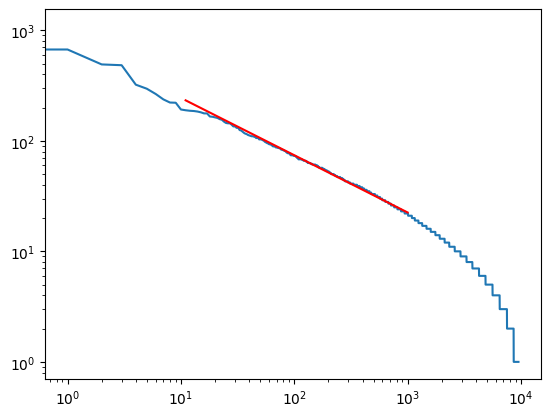

In [37]:
from scipy import stats

i0, i1 = 10, 1000
xs = np.array(list(range(1, len(sizes_sorted_by_cluster_sizes)+1)))[i0:i1]
ys = sizes_sorted_by_cluster_sizes[i0:i1]

# perform linear regression on log-log scale
logx = np.log(xs)
logy = np.log(ys)
slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)

plt.plot(list(range(len(sizes_sorted_by_cluster_sizes))), sizes_sorted_by_cluster_sizes)
# plot the line of best fit
plt.plot(xs, np.exp(intercept + slope * logx), 'r', label='fitted line')
plt.yscale('log')
plt.xscale('log')

In [39]:
print(slope) # wow this is way off from theory

-0.518108788901001


In [41]:
indices = defaultdict(list)
for i in range(len(labels)):
    indices[labels[i]].append(i)

In [111]:
l = labels_sorted_by_cluster_size[1007]
print_context(token_idxs[indices[l][0]])

Mutations in the Notch pathway alter the patterning of multifidus.
Clinical studies have suggested that defects in the epaxial muscles, particularly multifidus, may contribute to the etiology of idiopathic scoliosis. While the epaxial muscles and the vertebrae derive from the same embryonic segmentation process, the mechanisms that pattern the multisegmental back muscles are still unclear. The process of segmentation is regulated by the Notch signaling pathway, and mutations in the modulators delta-like 3 (Dll3) and lunatic fringe (Lfng) are genetic models for spinal disorders such as scoliosis. Osteological defects have been characterized in these genetic models, but myological phenotypes have not previously been studied. We analyzed the multifidus muscle in the mouse (Mus musculus


In [116]:
cluster_range = range(100, 4000)
clusters_data = defaultdict(list)
for i in tqdm(cluster_range):
    l = labels_sorted_by_cluster_size[i]
    for idx_i in indices[l]:
        idx = token_idxs[idx_i]
        doc, token_idx_within_doc = get_context(idx)
        tokens = doc["split_by_token"]
        clusters_data[i].append((tokens, token_idx_within_doc))

torch.save((clusters_data, labels), "../results/kmeans-first-try-clusters.pt")

  0%|          | 0/3900 [00:00<?, ?it/s]